In [6]:
import pandas as pd
import numpy as np

df = pd.read_csv("dataset/diamonds.csv")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [8]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


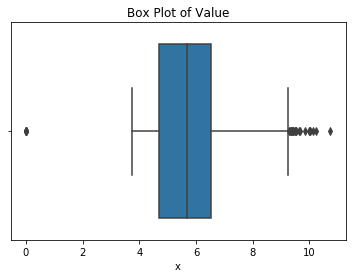

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(x=df['x'])
plt.title('Box Plot of Value')
plt.show()

In [32]:
# 1사분위수(Q1)와 3사분위수(Q3) 계산
Q1 = df['x'].quantile(0.25)
Q3 = df['x'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 경계 정의
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
# Q1: 4.71, Q3: 6.54, IQR: 1.83
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
# Lower Bound: 1.9649999999999999, Upper Bound: 9.285

# 이상치 탐지
outliers_iqr = df[(df['x'] < lower_bound) | (df['x'] > upper_bound)]
print("\n--- Outliers by IQR ---")
print(outliers_iqr)

# 이상치 대체 (Capping/Clipping)
df_capped = df.copy()
df_capped['x'] = np.clip(df['x'], lower_bound, upper_bound)
print("\n--- Capped DataFrame ---")
print(df_capped)

Q1: 4.71, Q3: 6.54, IQR: 1.83
Lower Bound: 1.9649999999999999, Upper Bound: 9.285

--- Outliers by IQR ---
       carat        cut color clarity  depth  table  price      x      y  \
11182   1.07      Ideal     F     SI2   61.6   56.0   4954   0.00   6.62   
11963   1.00  Very Good     H     VS2   63.3   53.0   5139   0.00   0.00   
15951   1.14       Fair     G     VS1   57.5   67.0   6381   0.00   0.00   
22741   3.01       Fair     H      I1   56.1   62.0  10761   9.54   9.38   
22831   3.00       Good     I      I1   57.0   64.0  10863   9.38   9.31   
23644   3.65       Fair     H      I1   67.1   53.0  11668   9.53   9.48   
24131   3.24    Premium     H      I1   62.1   58.0  12300   9.44   9.40   
24297   3.22      Ideal     I      I1   62.6   55.0  12545   9.49   9.42   
24328   3.50      Ideal     H      I1   62.8   57.0  12587   9.65   9.59   
24520   1.56      Ideal     G     VS2   62.2   54.0  12800   0.00   0.00   
24816   3.00    Premium     G      I1   59.7   60.0  1320

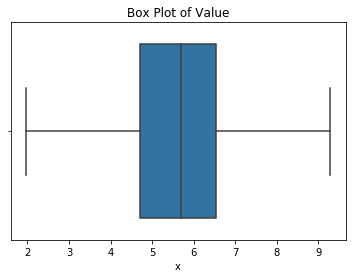

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(x=df_capped['x'])
plt.title('Box Plot of Value')
plt.show()